In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import set_matplotlib_formats


set_matplotlib_formats('svg')
%matplotlib inline
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [12., 8.]

In [2]:
from models.hardnet_segm import HardNetSegm
import cv2
import torch
from models.bts_estimator import BTSEstimator
from plane_detector import PlaneDetector
from models.midas_estimator import MIDASEstimator
from ransac_detector import crop_depth_map, get_connected_components, DEFAULT_CAM

In [3]:
hardnet_path = "models/segmnetator/hardnet70_cityscapes_model_2.pkl"
bts_path = "models/depth_estimator/models/bts_latest"


depth_model = MIDASEstimator()
segm_model = HardNetSegm(hardnet_path)

Using cache found in /home/ruslan/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/ruslan/.cache/torch/hub/facebookresearch_WSL-Images_master


Loading weights:  None


Using cache found in /home/ruslan/.cache/torch/hub/intel-isl_MiDaS_master


In [4]:
model = PlaneDetector(depth_model, segm_model)

In [5]:
%%time 
import os
import seaborn as sns
from tqdm import tqdm


path = "/home/ruslan/Документы/startup/FCHarDNet/data/leftImg8bit/val/frankfurt/"
files = os.listdir(path)

images = [cv2.imread(path + item) for item in tqdm(files)]

100%|██████████| 267/267 [00:27<00:00,  9.73it/s]

CPU times: user 21.4 s, sys: 1.71 s, total: 23.1 s
Wall time: 28.1 s


In [6]:
import random


def get_plane_img(img, ls_map_arrs, ls_inliers):
    """
    Function to plot detected planes on picture
    :param img:
    :param ls_map_arrs:
    :param ls_inliers:
    :return:
    """
    res = copy.deepcopy(img)
    for map_arr, inlier in zip(ls_map_arrs, ls_inliers):
        ls = np.argwhere(map_arr)
        np_ls = np.array(ls)
        color = [random.randint(0, 255) for _ in range(3)]
        for i, j in np_ls[inlier]:
            res[i][j] = color
    return res


In [7]:
def _get_plane_from_pcd(depth_map):
    img_3d = o3d.geometry.Image(np.float32(depth_map))
    pcd = o3d.geometry.PointCloud.create_from_depth_image(img_3d, DEFAULT_CAM, depth_scale=1)
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    arr = np.asarray(pcd.points)
    th = abs(np.max(arr) - np.min(arr)) / 100
    plane_model, inliers = pcd.segment_plane(distance_threshold=th,
                                         ransac_n=3,
                                         num_iterations=100)
    return plane_model, inliers


def extract_planes_con(map_arr, depth_map, start_size, t):
    curr_map_arr = copy.deepcopy(map_arr)
    plane_model, inliers = _get_plane_from_pcd(depth_map * curr_map_arr)

    result = []
    while len(inliers) >= int(start_size * t):
        ls = np.where(curr_map_arr)
        ans = np.zeros(curr_map_arr.shape)
        x, y = ls[0][inliers], ls[1][inliers]
        curr_map_arr[x, y] = 0
        ans[x, y] = 1
        result.append((ans, plane_model))
        plane_model, inliers = _get_plane_from_pcd(depth_map * curr_map_arr)
    return result
        
    


In [8]:
from models.depth_estimator.BTS import BtsController
import numpy as np
from functools import partial
import copy


def thr_func(q):
    return partial(np.quantile, q=q)

# img = cv2.imread("/home/ruslan/Документы/startup/research/data/paris/73_location_48.8611316,2.3401685/120/gsv_0.jpg")
# img = cv2.imread("/home/ruslan/Загрузки/72ac1342-b976-48ad-9c20-9197707c7e62.jpeg")
img = cv2.imread("/home/ruslan/Загрузки/test_corner2.jpg")
# img = copy.deepcopy(images[66])
img = cv2.resize(img, (640, 480))
depth_map, seg_map, ls_map_arr = model.get_segmented_depth(img, [{0, 1}, {2}])

In [9]:
N = 640 * 480

In [10]:
ls_right_depths = []
ls_tmp = []
funcs = [thr_func(0.95), np.mean]
for item, fun in zip(ls_map_arr, funcs):
    tmp, k = crop_depth_map(depth_map * item, fun)
    ls_right_depths.extend(get_connected_components(tmp, threshold=0.3))


In [11]:
import open3d as o3d
import os
import sys
import cv2

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

In [12]:
%%time
ls_right_map_arrs = [np.where(item[0] > 0, 1, 0) for item in ls_right_depths]
ls_maps_planes = []
ls_vectors_planes = []
for dd, map_arr in zip(ls_right_depths, ls_right_map_arrs):
    result = extract_planes_con(map_arr, dd[0], map_arr.sum(), 0.2)
    ls_maps_planes.extend([arr for arr, _ in result])
    ls_vectors_planes.extend([arr for _, arr in result])

CPU times: user 383 ms, sys: 3.47 ms, total: 387 ms
Wall time: 460 ms


In [13]:
ls_vectors_planes

[array([ 5.41942792e-02,  9.76852326e-01, -2.06936012e-01,  4.30385124e-05]),
 array([ 7.37225964e-01, -2.11793759e-01, -6.41592769e-01, -3.25084267e-04]),
 array([7.34473367e-01, 2.69879735e-01, 6.22666686e-01, 2.81235916e-04])]

In [14]:
ls_pcd = []
for item, (a, b, c, d) in zip(ls_maps_planes, ls_vectors_planes):
    tmp = o3d.geometry.Image(np.float32((1 / depth_map) * item))
    tt = o3d.geometry.PointCloud.create_from_depth_image(tmp, DEFAULT_CAM, depth_scale=1.0)
    tt.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    tt.paint_uniform_color([random.uniform(0, 1) for _ in range(3)])
    
    ls_pcd.append(tt)

    indeces = np.argwhere(item)
    color = [random.randint(1, 255) for _ in range(3)]
    for i, j in indeces:
        img[i][j] = color

In [25]:
from functools import reduce


def close_map(map_arr, kernels=None):
    """
    Function used for filling holes in map_arr
    :param map_arr: initial map_arr
    :param kernels: tuple of kernels used to fill holes in map
    :return: relusting map_arr after closing
    """
    if kernels is None:
        kernels = [np.ones((100, 10), np.uint8), np.ones((10, 100), np.uint8)]

    ls_closings = [cv2.morphologyEx(np.uint8(map_arr), cv2.MORPH_CLOSE, kernel) for kernel in kernels]
    return reduce(np.logical_and, ls_closings, np.ones(map_arr.shape))



def straight_pcd(map_arr, depth_map, plane_model):
    a, b, c, d = plane_model
    img = o3d.geometry.Image(np.float32(map_arr * depth_map))
    result = o3d.geometry.PointCloud.create_from_depth_image(img, DEFAULT_CAM)
    result.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    arr = np.asarray(result.points)
    new_points = np.array([[x, y, (-a * x - b * y - d) / c] for x, y, z in arr])
    vec = o3d.utility.Vector3dVector(new_points)
    result.points = vec
    return result


In [26]:
ls_new_pcd = [straight_pcd(close_map(map_arr), 1 / depth_map, plane) for map_arr, plane in zip(ls_maps_planes, ls_vectors_planes)]

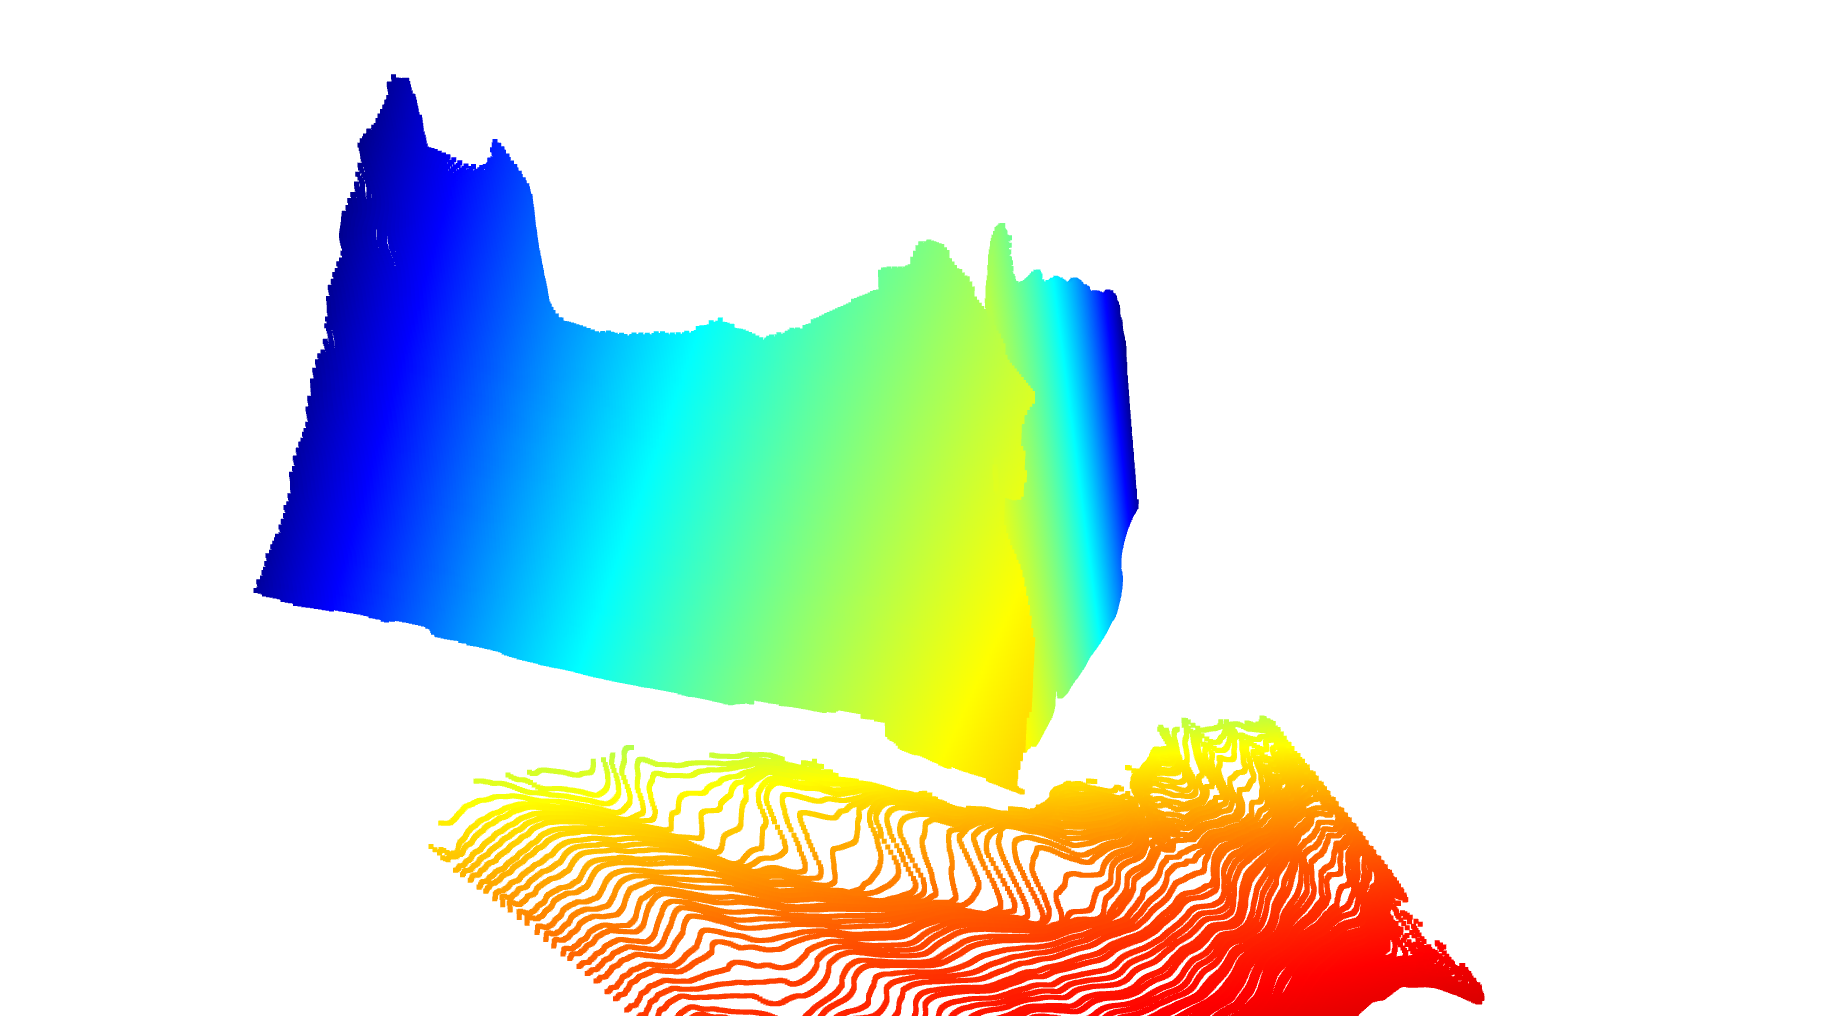

In [27]:
o3d.visualization.draw_geometries(ls_new_pcd, zoom=0.35)

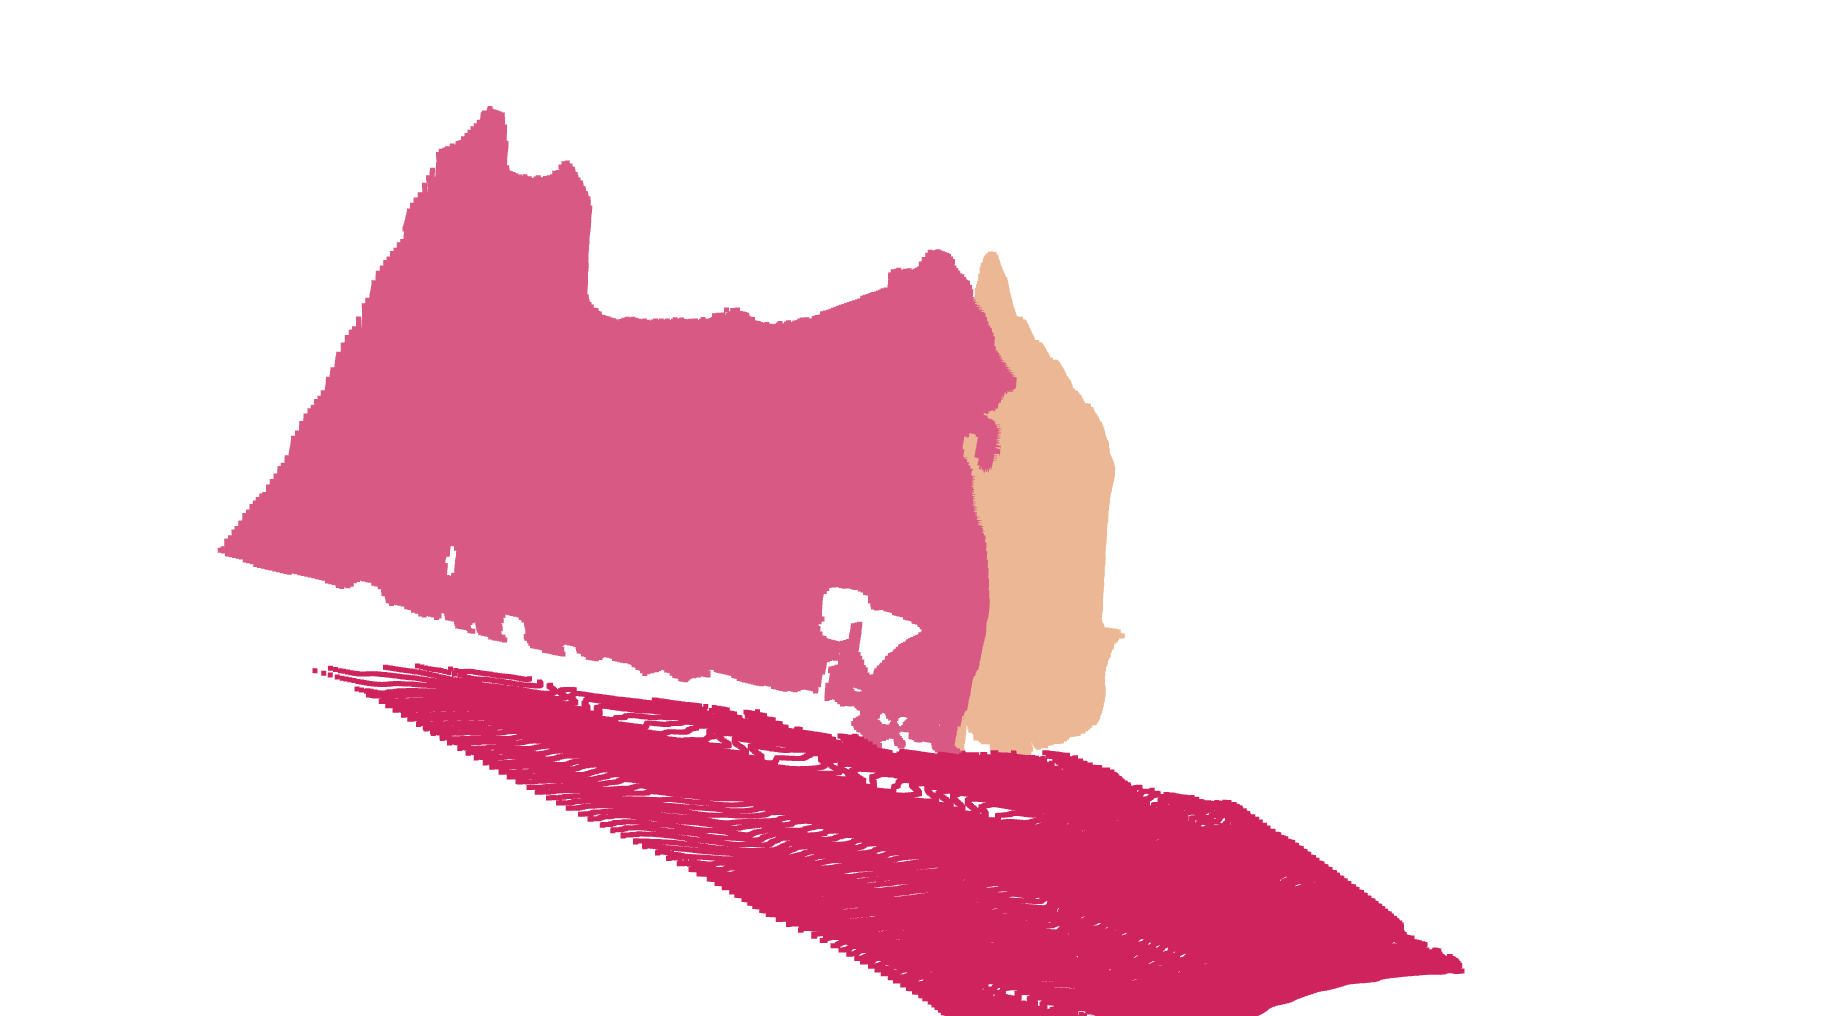

In [19]:
o3d.visualization.draw_geometries(ls_pcd, zoom=0.35)

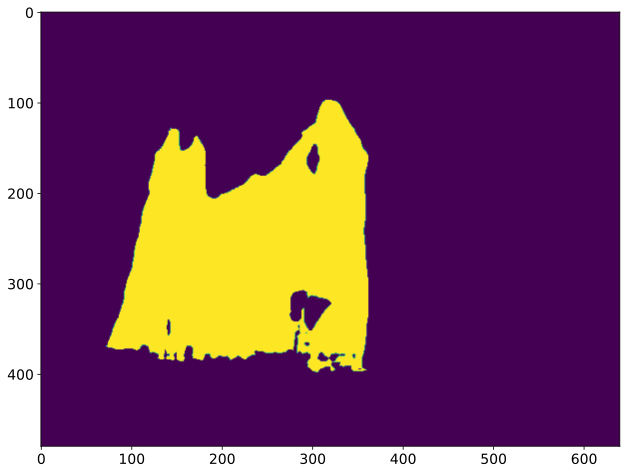

In [28]:
plt.imshow(ls_maps_planes[1])

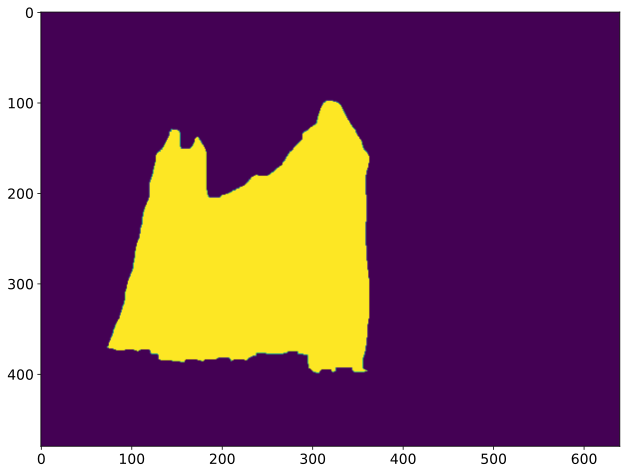

In [29]:
plt.imshow(close_map(ls_maps_planes[1]))

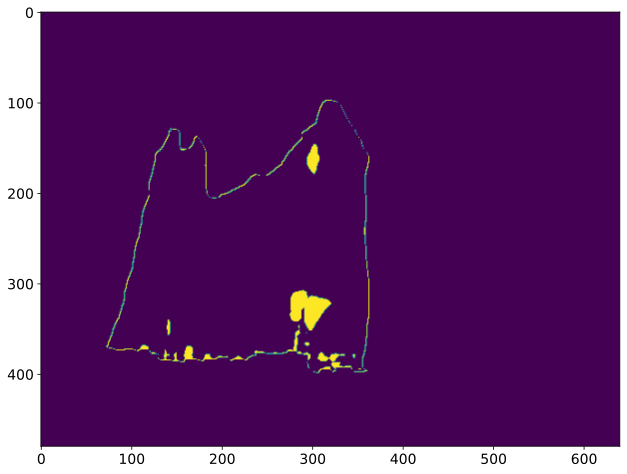

In [31]:
plt.imshow(np.logical_xor(close_map(ls_maps_planes[1]), ls_maps_planes[1]))

In [36]:
segm_model.model

hardnet(
  (base): ModuleList(
    (0): ConvLayer(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ConvLayer(
      (conv): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): ConvLayer(
      (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): ConvLayer(
      (conv): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

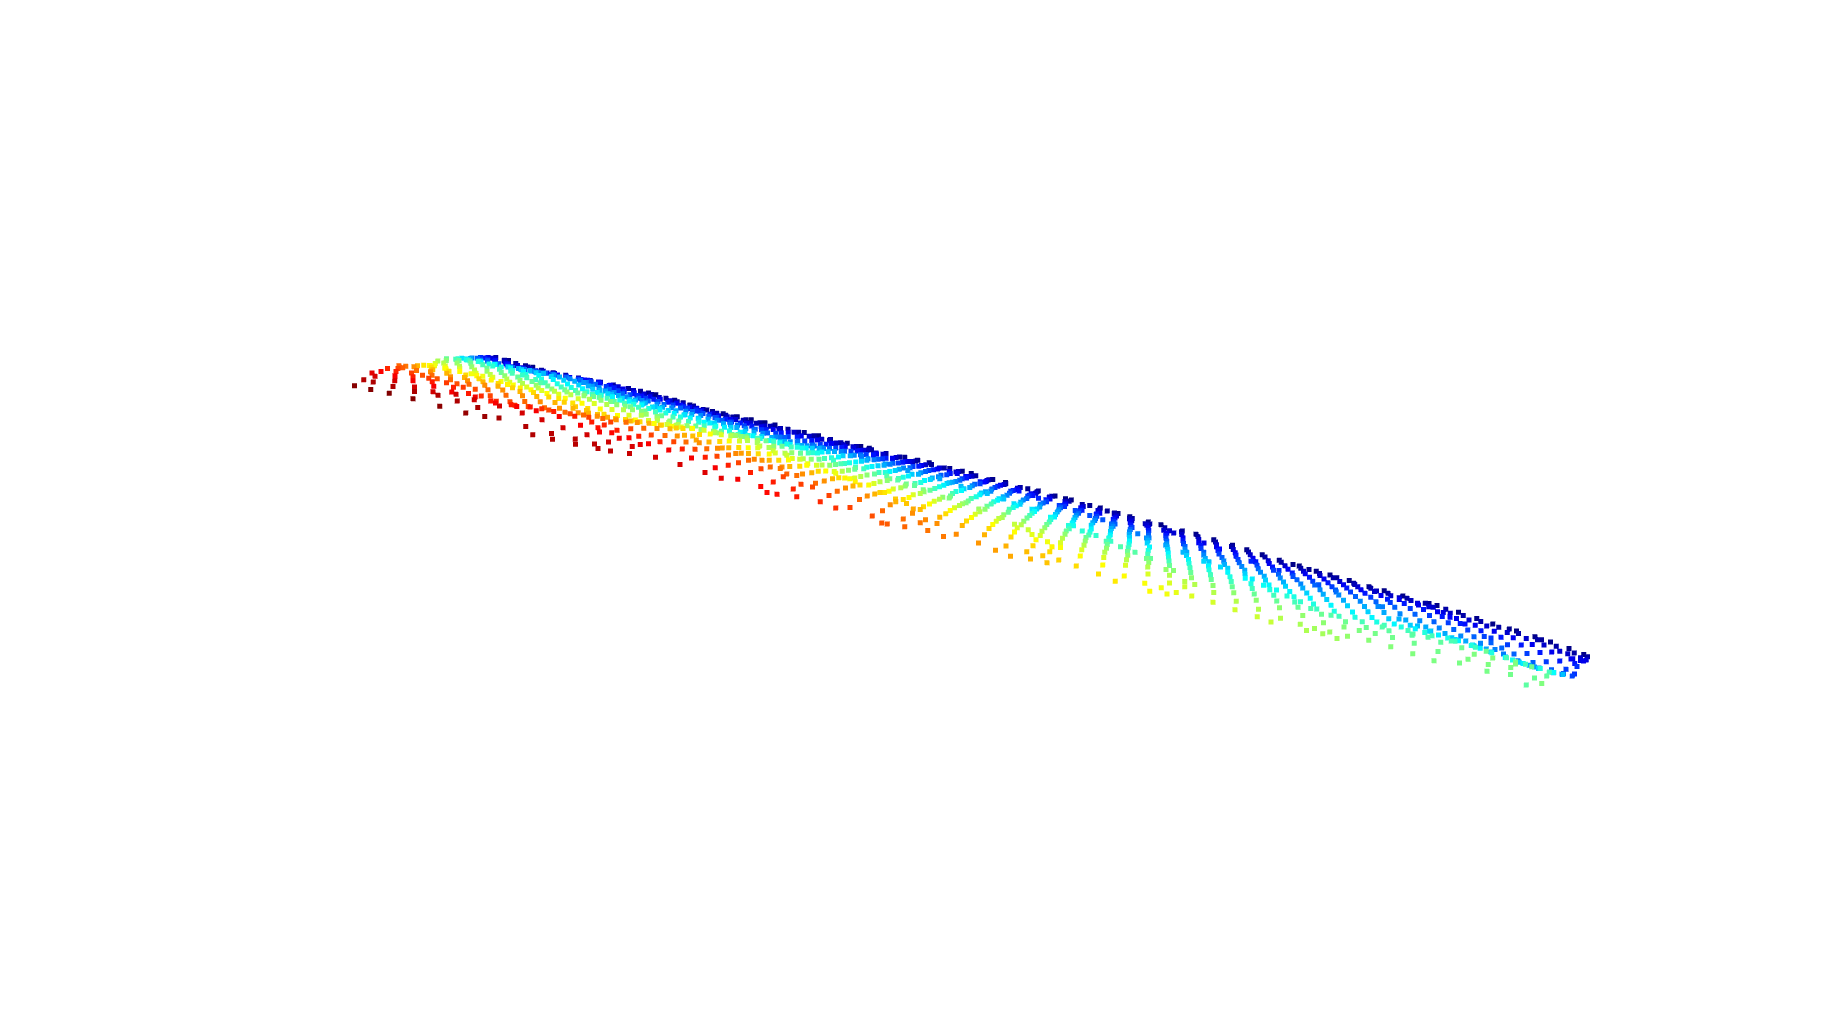

In [134]:
o3d.visualization.draw_geometries([downs], zoom=0.35)

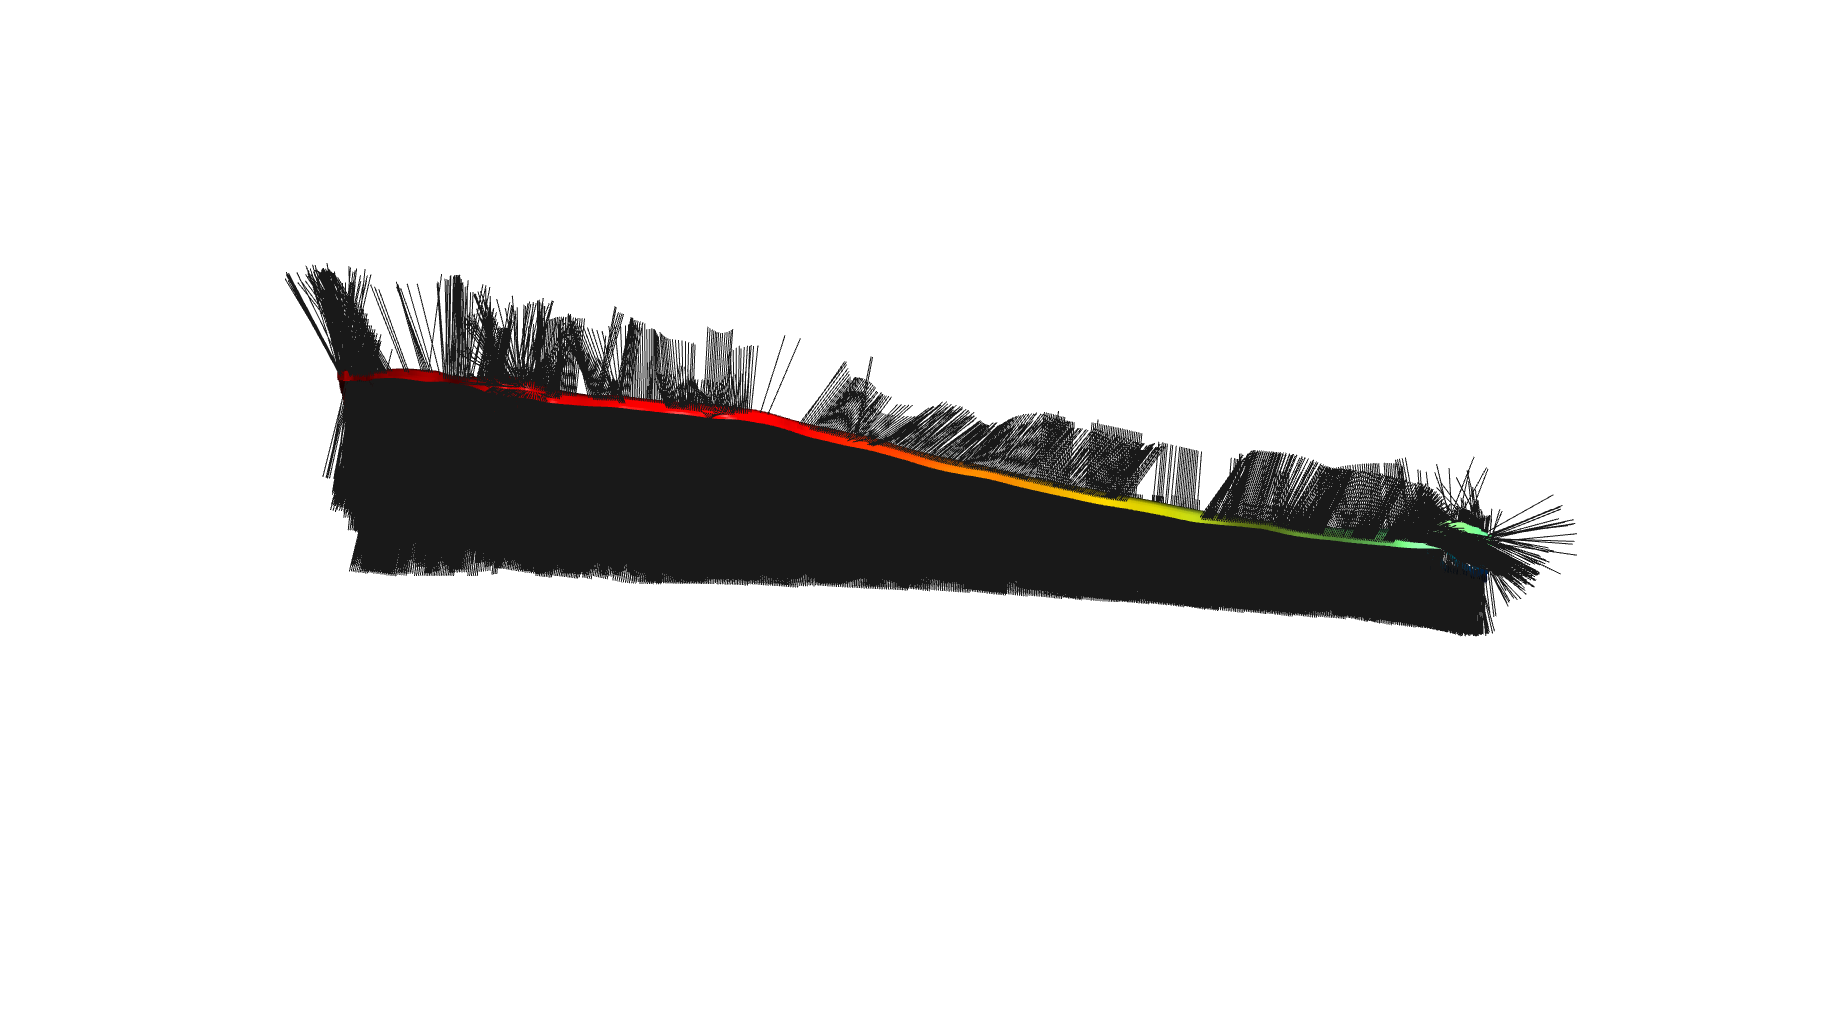

In [135]:
pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.2, max_nn=30))
o3d.visualization.draw_geometries([pcd], zoom=0.35)

Plane equation: 0.06x + 0.98y + -0.21z + 0.00 = 0


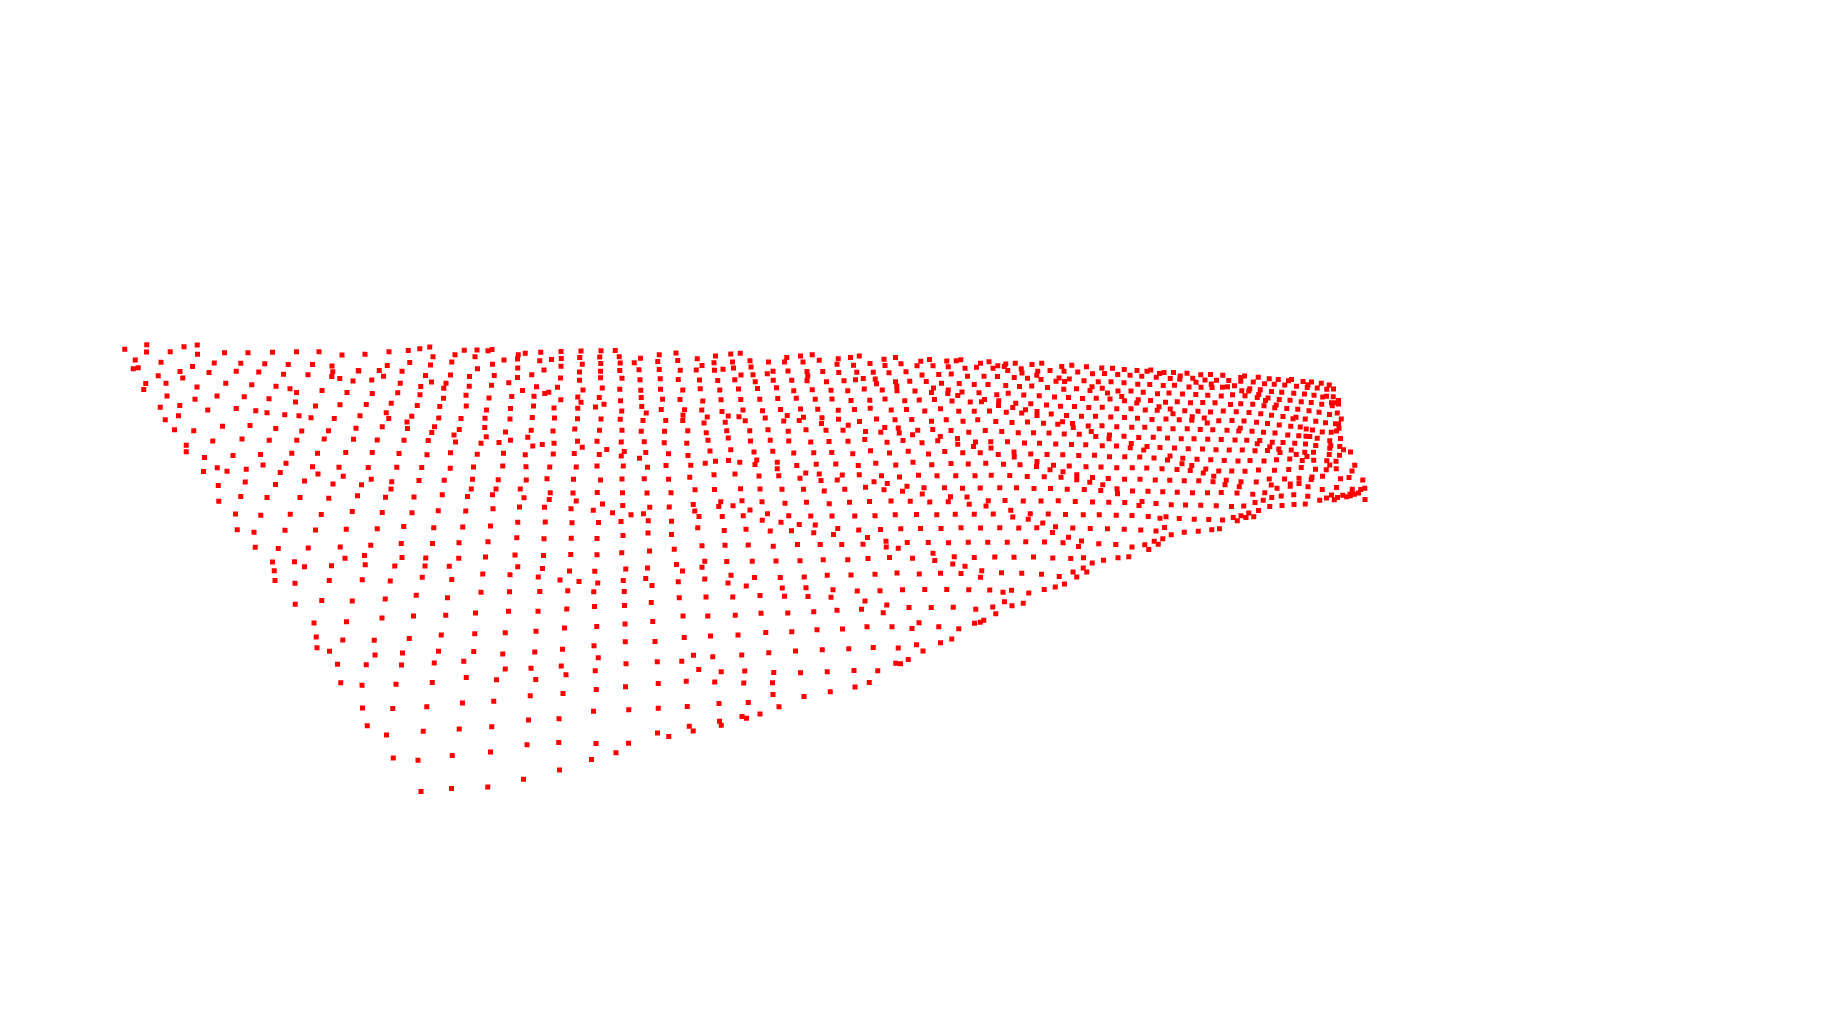

In [136]:
plane_model, inliers = downs.segment_plane(distance_threshold=0.00002,
                                         ransac_n=3,
                                         num_iterations=100)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = downs.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = downs.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.35)
# Plane equation: 0.90x + -0.16y + 0.42z + 6.26 = 0


In [138]:
downs.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.2, max_nn=30))


True

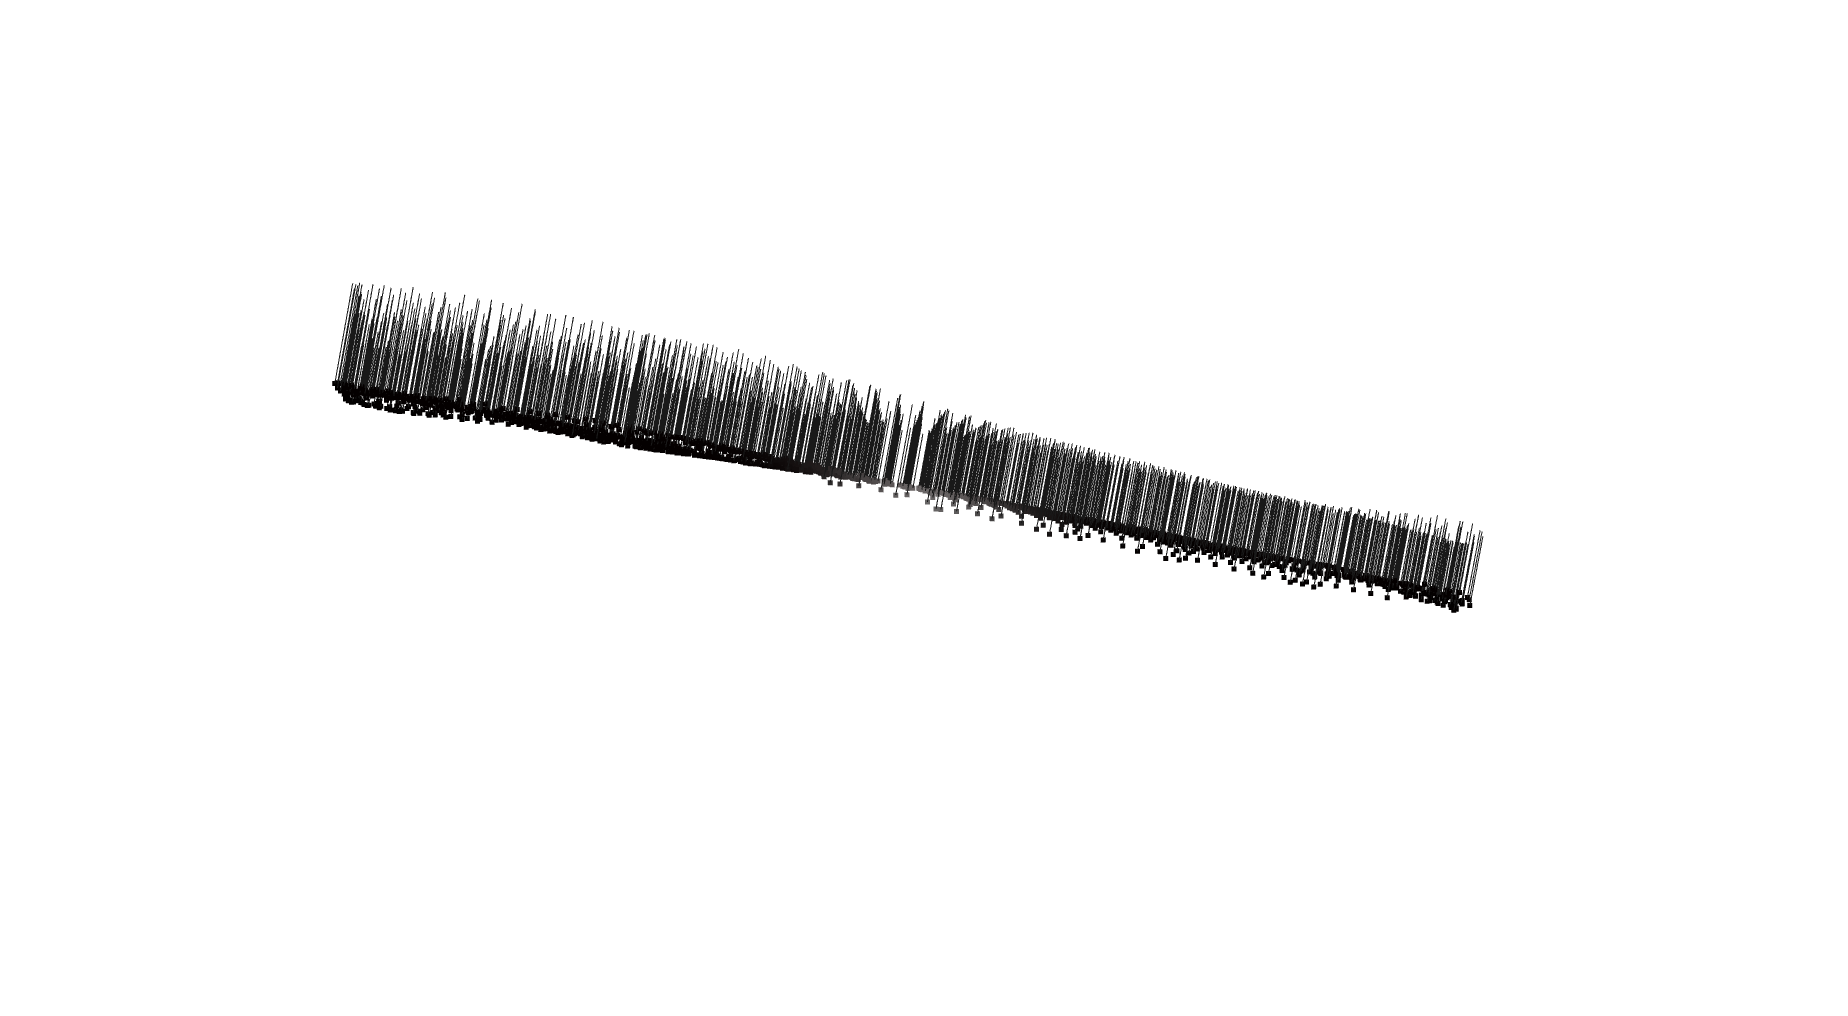

In [139]:
downs.normals = o3d.utility.Vector3dVector(np.array([np.array([a, b, c]) for _ in range(np.asarray(downs.normals).shape[0])]))

inlier_cloud1 = downs.select_by_index(inliers)
inlier_cloud1.paint_uniform_color([1.0, 0, 0])
outlier_cloud1 = downs.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud1, outlier_cloud1],
                                  zoom=0.35)

In [99]:
udowns = pcd.uniform_down_sample(4)

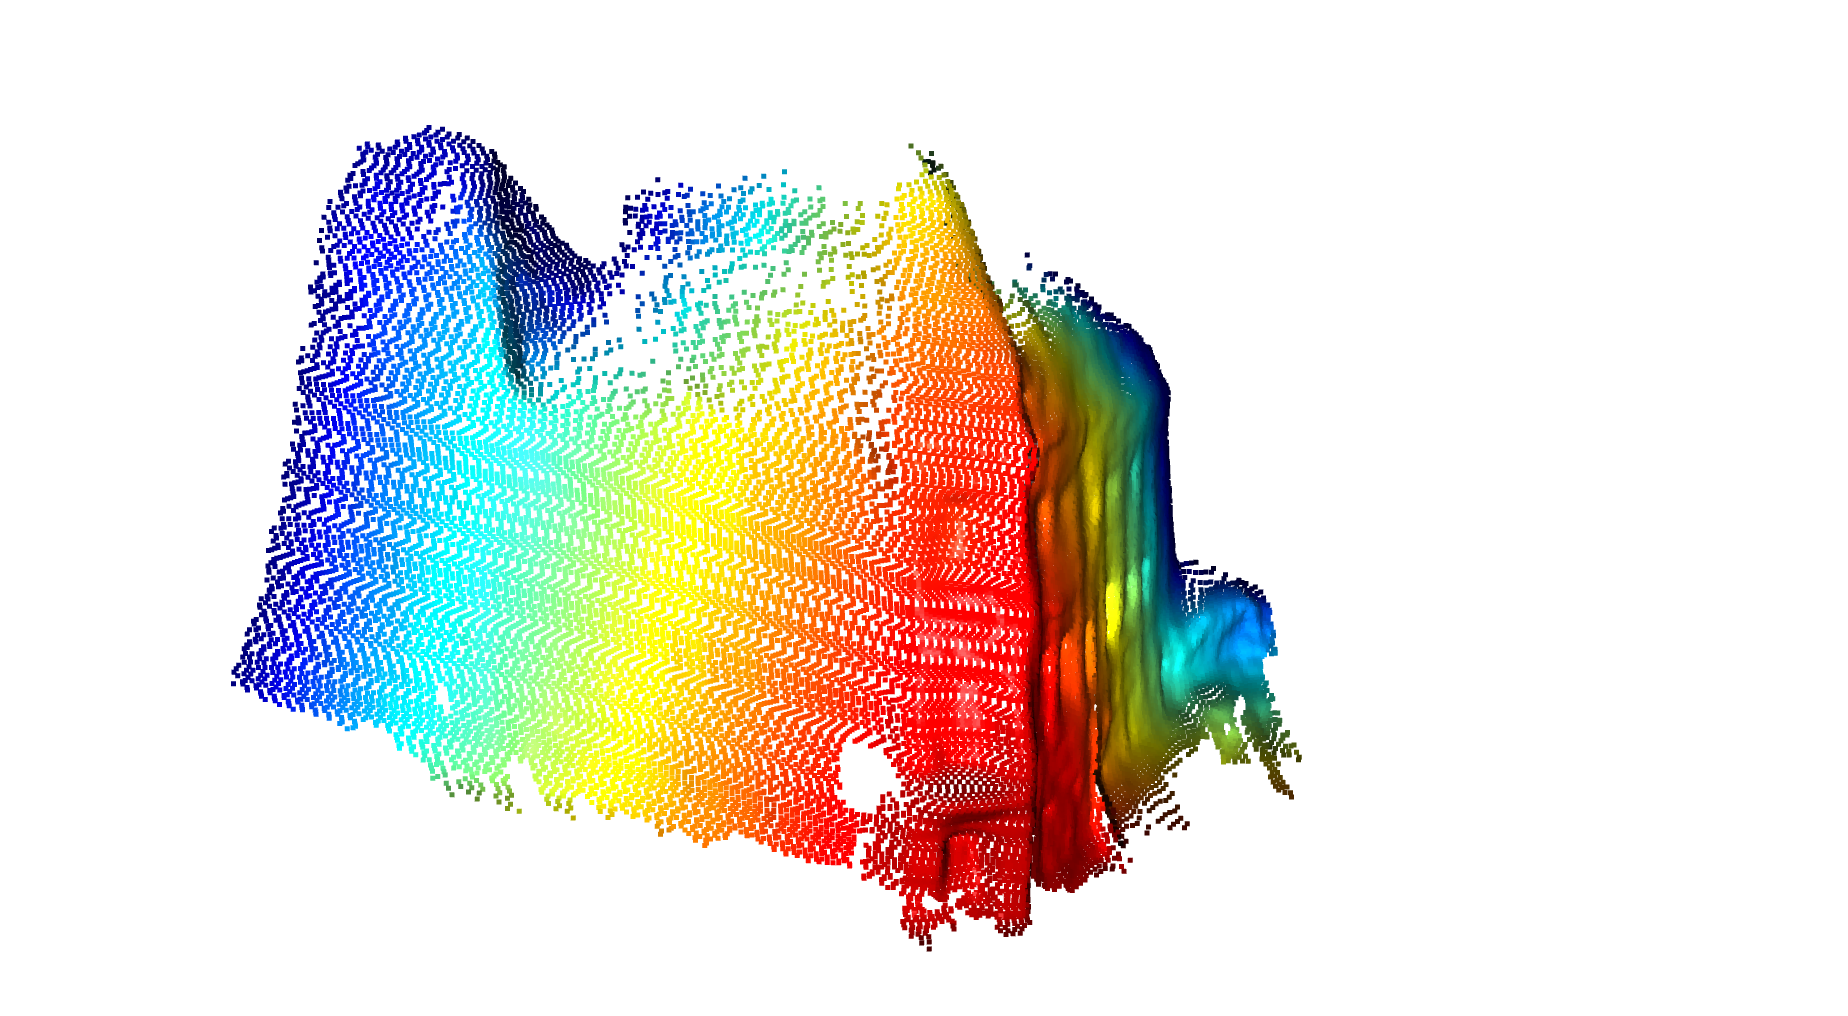

In [101]:
o3d.visualization.draw_geometries([udowns],
                                  zoom=0.35)

In [115]:
np.asarray(pcd.points).shape

(166889, 3)

Plane equation: 0.96x + 0.01y + 0.26z + 0.00 = 0


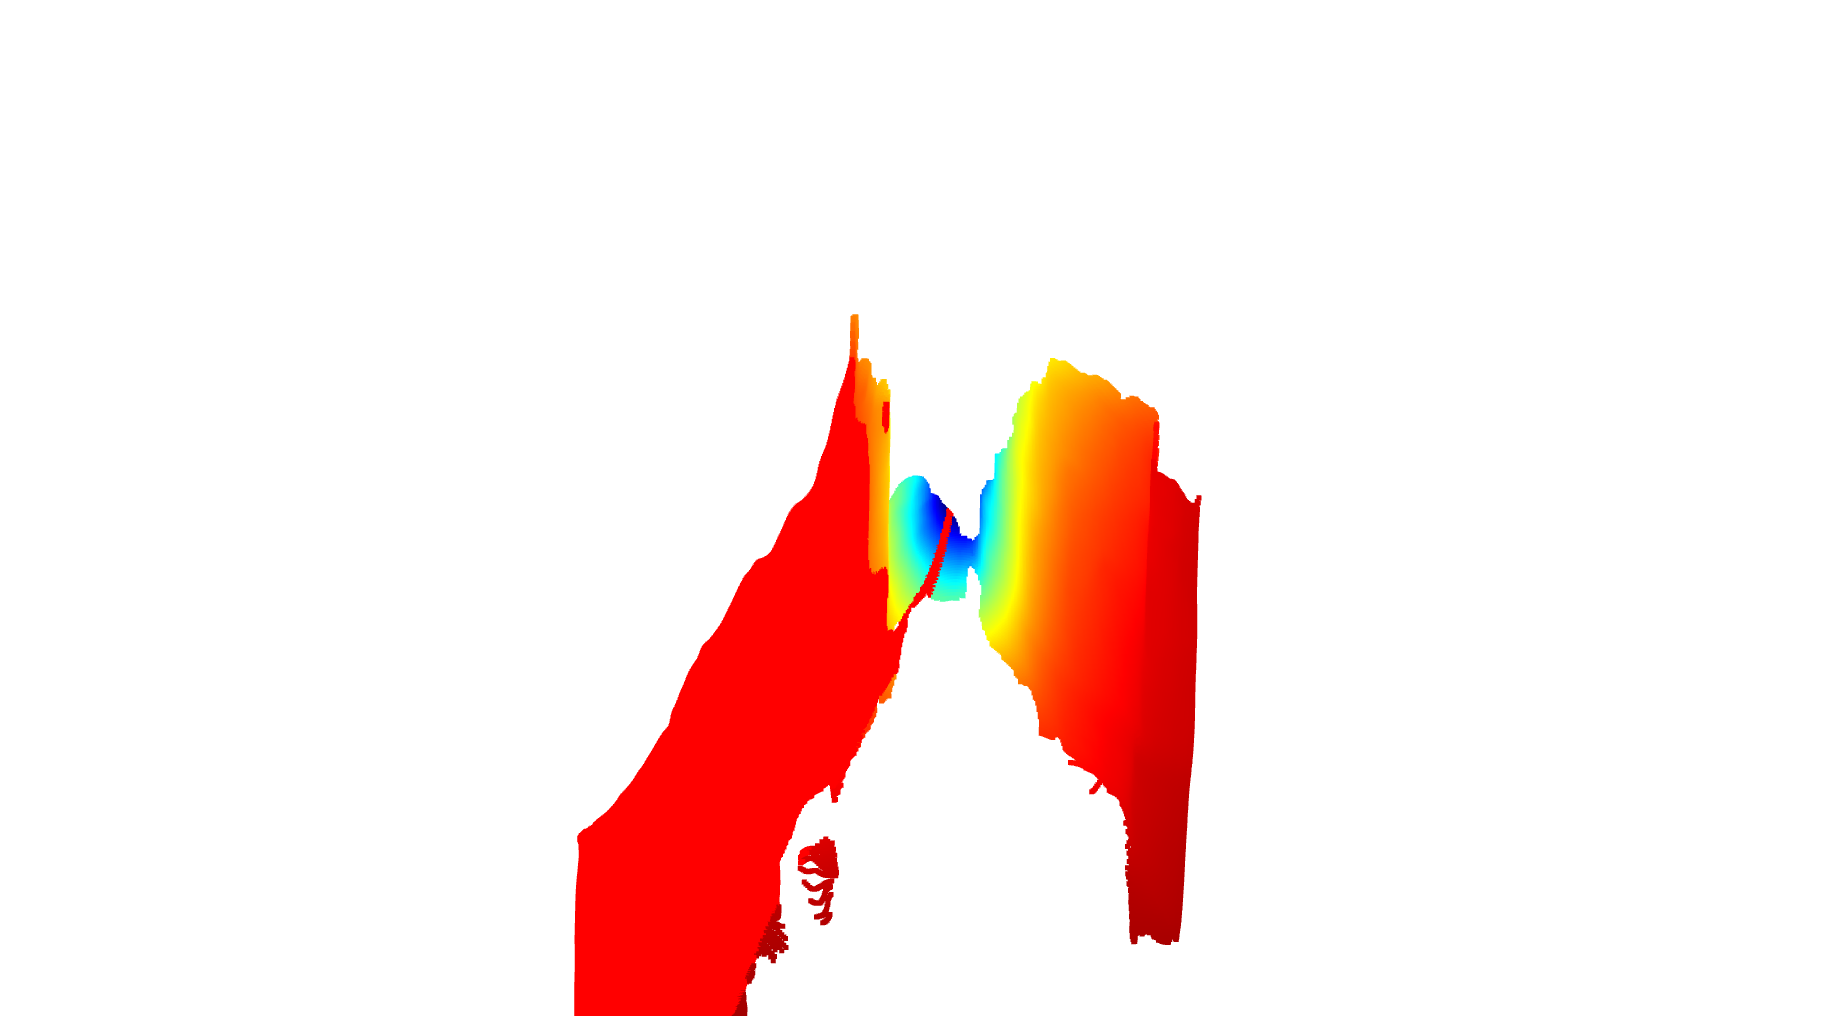

In [113]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.00002,
                                         ransac_n=3,
                                         num_iterations=300)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.35)
# Plane equation: 0.90x + -0.16y + 0.42z + 6.26 = 0


In [114]:
np.asarray(inlier_cloud.points).shape

(120666, 3)

Plane equation: 0.97x + -0.17y + 0.19z + -0.00 = 0


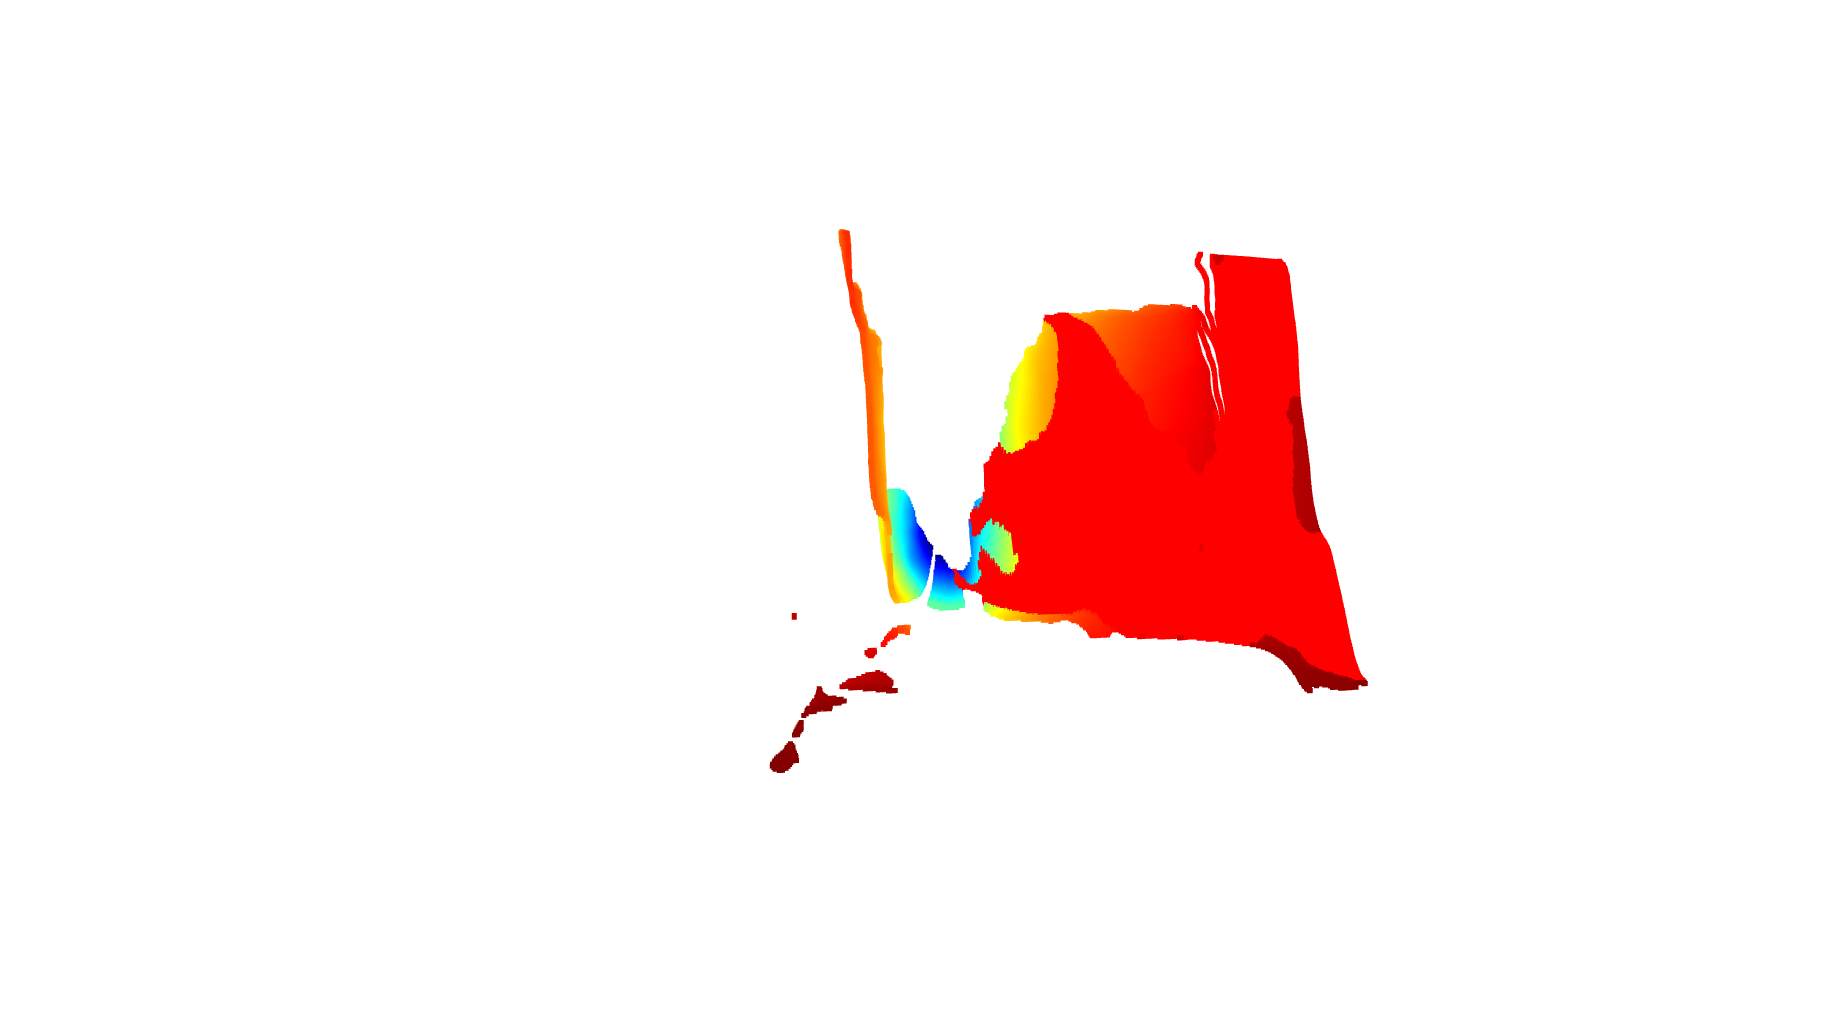

In [116]:
plane_model, inliers = outlier_cloud.segment_plane(distance_threshold=0.00002,
                                         ransac_n=3,
                                         num_iterations=300)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = outlier_cloud.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = outlier_cloud.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.35)
# Plane equation: 0.90x + -0.16y + 0.42z + 6.26 = 0


In [118]:
help(cv2.connectedComponentsWithAlgorithm)

Help on built-in function connectedComponentsWithAlgorithm:

connectedComponentsWithAlgorithm(...)
    connectedComponentsWithAlgorithm(image, connectivity, ltype, ccltype[, labels]) -> retval, labels
    .   @brief computes the connected components labeled image of boolean image
    .   
    .   image with 4 or 8 way connectivity - returns N, the total number of labels [0, N-1] where 0
    .   represents the background label. ltype specifies the output label image type, an important
    .   consideration based on the total number of labels or alternatively the total number of pixels in
    .   the source image. ccltype specifies the connected components labeling algorithm to use, currently
    .   Grana (BBDT) and Wu's (SAUF) algorithms are supported, see the #ConnectedComponentsAlgorithmsTypes
    .   for details. Note that SAUF algorithm forces a row major ordering of labels while BBDT does not.
    .   This function uses parallel version of both Grana and Wu's algorithms if at leas